In [1]:
%%sh
#git clone https://github.com/jcboyd/multi-cell-line.git
#ln -s multi-cell-line/src

In [1]:
from datasets import Boyd2019

metadata = Boyd2019.read_metadata('data/boyd_2019_PlateMap-KPP_MOA.xlsx')

ds = Boyd2019('data/boyd_2019', metadata)

In [6]:
metadata

,plate,id,well,content,concentration,moa,target1,target2,source
0,Plate_KinInh_1_P1_P1,A - 01,A01,DMSO,NaN,Neutral,NaN,NaN,https://en.wikipedia.org/wiki/Dimethyl_sulfoxide
1,Plate_KinInh_1_P1_P1,A - 02,A02,DMSO,NaN,Neutral,NaN,NaN,https://en.wikipedia.org/wiki/Dimethyl_sulfoxide
2,Plate_KinInh_1_P1_P1,A - 03,A03,DMSO,NaN,Neutral,NaN,NaN,https://en.wikipedia.org/wiki/Dimethyl_sulfoxide
3,Plate_KinInh_1_P1_P1,A - 04,A04,DMSO,NaN,Neutral,NaN,NaN,https://en.wikipedia.org/wiki/Dimethyl_sulfoxide
4,Plate_KinInh_1_P1_P1,A - 05,A05,DMSO,NaN,Neutral,NaN,NaN,https://en.wikipedia.org/wiki/Dimethyl_sulfoxide
...,...,...,...,...,...,...,...,...,...
379,Plate_KinInh_1_P1_P1,P - 20,P20,None,NaN,Wild,NaN,NaN,https://en.wikipedia.org/wiki/Nothing
380,Plate_KinInh_1_P1_P1,P - 21,P21,DMSO,NaN,Neutral,NaN,NaN,https://en.wikipedia.org/wiki/Dimethyl_sulfoxide
381,Plate_KinInh_1_P1_P1,P - 22,P22,Olaparib,1 µM,PARP Inhibitor,NaN,NaN,https://en.wikipedia.org/wiki/Nothing
382,Plate_KinInh_1_P1_P1,P - 23,P23,DMSO,NaN,Neutral,NaN,NaN,https://en.wikipedia.org/wiki/Dimethyl_sulfoxide


In [2]:
ds.mda231.shape

torch.Size([891, 3, 64, 64])

In [3]:
metadata

,plate,id,well,content,concentration,moa,target1,target2,source
0,Plate_KinInh_1_P1_P1,A - 01,A01,DMSO,NaN,Neutral,NaN,NaN,https://en.wikipedia.org/wiki/Dimethyl_sulfoxide
1,Plate_KinInh_1_P1_P1,A - 02,A02,DMSO,NaN,Neutral,NaN,NaN,https://en.wikipedia.org/wiki/Dimethyl_sulfoxide
2,Plate_KinInh_1_P1_P1,A - 03,A03,DMSO,NaN,Neutral,NaN,NaN,https://en.wikipedia.org/wiki/Dimethyl_sulfoxide
3,Plate_KinInh_1_P1_P1,A - 04,A04,DMSO,NaN,Neutral,NaN,NaN,https://en.wikipedia.org/wiki/Dimethyl_sulfoxide
4,Plate_KinInh_1_P1_P1,A - 05,A05,DMSO,NaN,Neutral,NaN,NaN,https://en.wikipedia.org/wiki/Dimethyl_sulfoxide
...,...,...,...,...,...,...,...,...,...
379,Plate_KinInh_1_P1_P1,P - 20,P20,None,NaN,Wild,NaN,NaN,https://en.wikipedia.org/wiki/Nothing
380,Plate_KinInh_1_P1_P1,P - 21,P21,DMSO,NaN,Neutral,NaN,NaN,https://en.wikipedia.org/wiki/Dimethyl_sulfoxide
381,Plate_KinInh_1_P1_P1,P - 22,P22,Olaparib,1 µM,PARP Inhibitor,NaN,NaN,https://en.wikipedia.org/wiki/Nothing
382,Plate_KinInh_1_P1_P1,P - 23,P23,DMSO,NaN,Neutral,NaN,NaN,https://en.wikipedia.org/wiki/Dimethyl_sulfoxide


In [2]:
import os
import sys
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils import *
from src.feature_reader import FeatureReader
from src.vis_utils import image_crop_training_set

data_path = 'multi-cell-line/cecog_out_propagate_0.5'
metadata_file = 'multi-cell-line/PlateMap-KPP_MOA.xlsx'
df_metadata = pd.read_excel(metadata_file, engine='openpyxl').set_index('well')

# Create drug type column
df_metadata.loc[df_metadata['content'] != 'DMSO', 'category'] = 'Perturbation'
df_metadata.loc[df_metadata['content'] == 'DMSO', 'category'] = 'DMSO'
df_metadata.loc[df_metadata['content'] == 'None', 'category'] = 'None'
df_metadata.loc[df_metadata['content'] == 'Olaparib', 'category'] = 'Positive'
df_metadata.loc[df_metadata['content'] == 'Cisplatine', 'category'] = 'Positive'

# Remove drugs
df_metadata = df_metadata.drop(df_metadata[df_metadata['moa'] == 'Wild'].index)

# Remove wells without content
df_metadata = df_metadata[~df_metadata.content.isnull()]

channels = ['primary__primary4', 'secondary__propagate', 'tertiary__expanded']
plates = {'mda231' : '22_384_20X-hNA_D_F_C3_C5_20160031_2016.01.25.17.23.13_MDA231',
          'mda468' : '22_384_20X-hNA_D_F_C3_C5_20160032_2016.01.25.16.27.22_MDA468'}

plate_data = {}

for cell_line in plates.keys():
    
    ch5_path = '%s/%s/hdf5/' % (data_path, plates[cell_line])

    # read handcrafted features
    fr = FeatureReader(plates[cell_line], ch5_path, channels, cell_line)
    fr.read_all()
    fr.data['cell_line'] = cell_line
    plate_data[cell_line] = fr

    problem_feature = 'primary__primary4_dyn_distance_radius_3'
    fr.data = fr.data.drop(problem_feature, axis=1)
    fr.feature_names.remove(problem_feature)

    # Join metadata
    fr.join_plate_map(df_metadata.reset_index())
    fr.data = fr.data[~fr.data['content'].isnull()]

Reading cell data...
Reading cell centers...
Reading primary__primary4 features...
Reading secondary__propagate features...
Reading tertiary__expanded features...
Removing invalid data...
Done!
Reading cell data...
Reading cell centers...
Reading primary__primary4 features...
Reading secondary__propagate features...
Reading tertiary__expanded features...
Removing invalid data...
Done!


In [3]:
df_mda231 = plate_data['mda231'].data
mda231_wells = set(df_mda231.well)

df_mda468 = plate_data['mda468'].data
mda468_wells = set(df_mda468.well)

common_wells = mda231_wells.intersection(mda468_wells)

df_pooled = pd.concat([df_mda231[df_mda231.well.isin(common_wells)],
                       df_mda468[df_mda468.well.isin(common_wells)]])

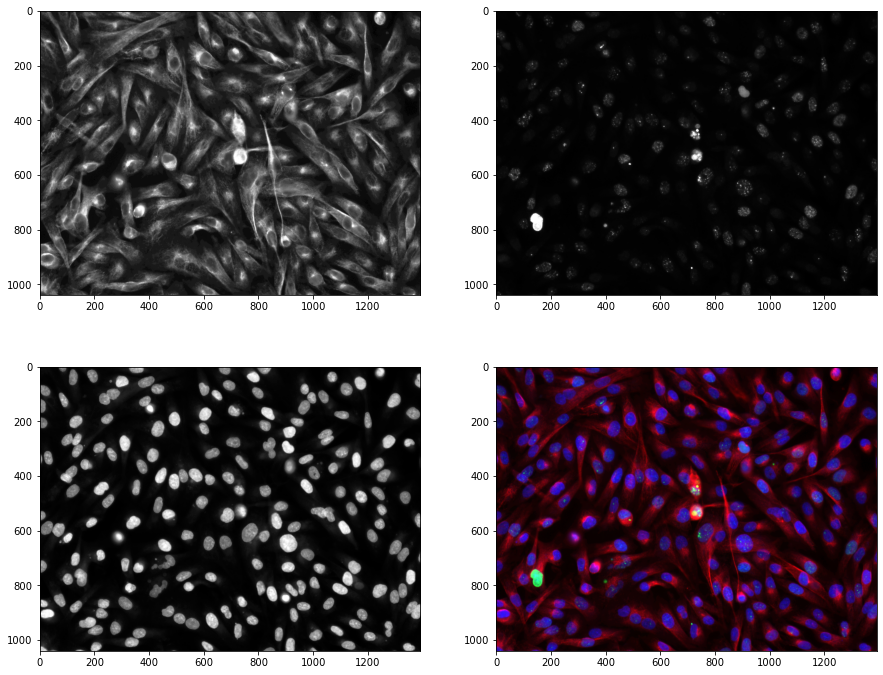

In [4]:
from src.vis_utils import ImageCropper

cell_line = 'mda231'
ch5_path = '%s/%s/hdf5/' % (data_path, plates[cell_line])

ic = ImageCropper('A01', 1, ch5_path)
img = ic.get_image()

fig, axes = plt.subplots(figsize=(15, 12), ncols=2, nrows=2)

axes[0][0].imshow(img[..., 0], cmap='Greys_r')
axes[0][1].imshow(img[..., 1], cmap='Greys_r')
axes[1][0].imshow(img[..., 2], cmap='Greys_r')
axes[1][1].imshow(img)

In [5]:
df_mda231 = plate_data['mda231'].data
mda231_wells = set(df_mda231.well)

df_mda468 = plate_data['mda468'].data
mda468_wells = set(df_mda468.well)

common_wells = mda231_wells.intersection(mda468_wells)

df_pooled = pd.concat([df_mda231[df_mda231.well.isin(common_wells)],
                       df_mda468[df_mda468.well.isin(common_wells)]])

# Make datasets

In [6]:
from src.vis_utils import image_crop_training_set

# choose train_fold_ix in range(60)
train_fold_ix = 43
crop_size = 64

def crop_cells(cell_line, fold_ix, crop_size, train_fold_ix=None):
    
    # read pre-sampled wells from file
    df_wells = pd.read_csv('multi-cell-line/datasets.csv', index_col=0)
    fold_wells = set(df_wells.loc[fold_ix])
    train_fold_wells = set(df_wells.loc[train_fold_ix]) if train_fold_ix else set()
    fold_wells = sorted(list(fold_wells - train_fold_wells))
        
    df_fold = df_pooled[df_pooled.well.isin(fold_wells)].copy()
    df_fold = df_fold[df_fold.cell_line == cell_line]

    # make crops
    ch5_path = '%s/%s/hdf5/' % (data_path, plates[cell_line])
    crops = image_crop_training_set(df_fold, ch5_path, crop_size, 0.5)
    crops = np.moveaxis(crops, 3, 1)
    crops = torch.from_numpy(crops)
    
    # normalize data
    mean = torch.mean(crops, dim=0)
    std = torch.std(crops, dim=0)
    crops = (crops - mean) / (std + 1e-5)

#     print(crops.shape)
#     print('%.02f Mb' % (sys.getsizeof(crops) / float(10 ** 6)))
    
    return [ x for x in zip(crops, df_fold['moa']) ]

# Data generator

In [7]:
from socket import gethostname

import torch
from torch.utils.data import DataLoader
import torchvision

from datasets import MultiCellDataset

def imshow(img, text=None, should_save=False):

    fig, ax = plt.subplots(figsize=(15, 5))

    npimg = img.numpy()

    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')
    plt.show()

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

# training params
train_batch_size = 64
train_number_epochs = 10
train_hosts = ['lion','inu']
# train_hosts.extend(['tael.local'])

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

if (gethostname() in train_hosts):
    mda231 = crop_cells('mda231', train_fold_ix, crop_size)
    mda468 = crop_cells('mda468', train_fold_ix, crop_size)

    siamese_dataset = MultiCellDataset(mda468, mda231)
    
    vis_dataloader = DataLoader(siamese_dataset,
                                shuffle=True,
                                num_workers=8,
                                batch_size=8)
    dataiter = iter(vis_dataloader)

    example_batch = next(dataiter)
    concatenated = torch.cat((example_batch[0],example_batch[2]),0)
    print(example_batch[4].numpy())
    imshow(torchvision.utils.make_grid(concatenated))

cpu


# Training

In [8]:
import torch
from torch import optim

from networks import SiameseNet
from losses import ContrastiveLoss

if (gethostname() in train_hosts):

    train_dataloader = DataLoader(siamese_dataset,
                                  shuffle=True,
                                  num_workers=8,
                                  batch_size=train_batch_size)

    net = SiameseNet().to(device)
    criterion = ContrastiveLoss()
    optimizer = optim.Adam(net.parameters(), lr = 0.0005)
    
    counter = []
    loss_history = [] 
    iteration_number= 0

    for epoch in range(0,train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, moa0, img1, moa1, label = data
            img0, img1, label = img0.to(device), img1.to(device) , label.to(device)
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i %10 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())

        torch.save(net.state_dict(), 'siamese_%04d.torch' % epoch)

    show_plot(counter,loss_history)

# Testing

In [9]:
# load saved net
net = SiameseNet().to(device)
net.load_state_dict(torch.load('siamese_0999.torch', map_location=torch.device('cpu')))
net = net.eval()

In [18]:
# get test set: different wells than training
test_fold_ix = 25

test_mda231 = crop_cells('mda231', test_fold_ix, crop_size, train_fold_ix)
test_mda468 = crop_cells('mda468', test_fold_ix, crop_size, train_fold_ix)

test_siamese_dataset = MultiCellDataset(test_mda468, test_mda231)

test_dataloader = DataLoader(test_siamese_dataset,
                             shuffle=True,
                             num_workers=8,
                             batch_size=train_batch_size)

In [19]:
# sample test set
embedding = np.empty((0,256))
moas = []
cell_line = np.empty((0,))

for i, data in enumerate(test_dataloader,0):
    img0, moa0, img1, moa1, _ = data
    img0, img1 = img0.to(device), img1.to(device)
    output1,output2 = net(img0,img1)
    
    embedding = np.concatenate((embedding, output1.detach().numpy(), output2.detach().numpy()))
    cell_line = np.concatenate((cell_line,
                                np.repeat('mda468', output1.shape[0]),
                                np.repeat('mda231', output2.shape[0])))
    moas.extend(moa0)
    moas.extend(moa1)
    
    if i == 100:
        break

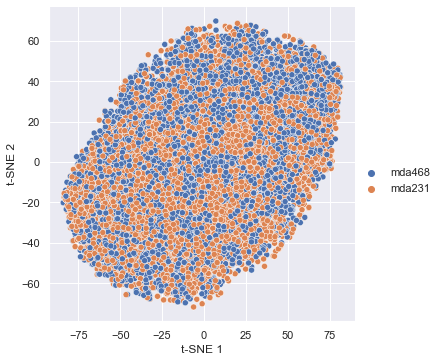

In [20]:
from viz import tsne,umap

tsne(embedding, cell_line)

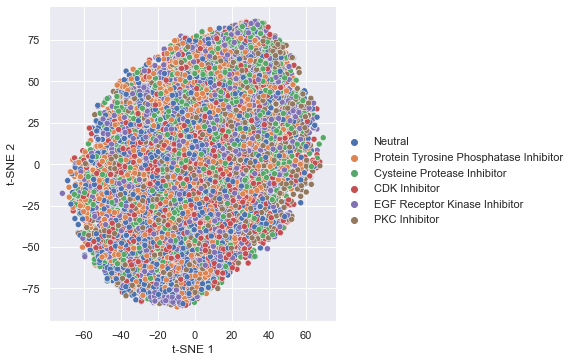

In [21]:
tsne(embedding, moas)